In [1]:
pip install opendatasets --upgrade

Installing Libraries

In [2]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import skimage.transform as tf


matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
project_name='brain-tumour-proj'

Importing MRI Dataset from Kaggle, url in below code

In [4]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri'
od.download('https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jashbari
Your Kaggle Key: ··········


  6%|▌         | 5.00M/86.8M [00:00<00:02, 35.1MB/s]

100%|██████████| 86.8M/86.8M [00:00<00:00, 101MB/s] 


In [5]:
data_dir='/content/brain-tumor-classification-mri'
print(os.listdir(data_dir))
classes=(os.listdir('/content/brain-tumor-classification-mri/Training'))
classes

['Testing', 'Training']


['no_tumor', 'pituitary_tumor', 'glioma_tumor', 'meningioma_tumor']

In [6]:
dataset=ImageFolder('/content/brain-tumor-classification-mri/Training' , transform=ToTensor())

torch.Size([3, 512, 512]) 0


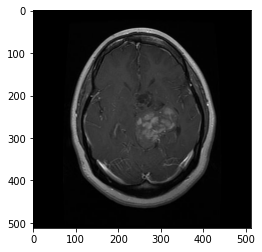

In [7]:
img, label = dataset[0]
print(img.shape,label)
plt.imshow(img.permute(1,2,0))

Preliminary Data preprocessing and augmentation

In [8]:
# Data Augmentation
train_tfms = tt.Compose([
                         tt.RandomHorizontalFlip(),
                         tt.Scale((224,224)),                            
                         tt.RandomRotation((-45,45)),
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                          tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor()])
valid_tfms = tt.Compose([tt.ToTensor(),tt.Scale((224,224))])

In [9]:
train_ds=ImageFolder('/content/brain-tumor-classification-mri/Training' , train_tfms)
valid_ds=ImageFolder('/content/brain-tumor-classification-mri/Testing' , valid_tfms)


In [42]:
batch_size=256
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

Lets Visualize our data by showing a batch of images


In [13]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

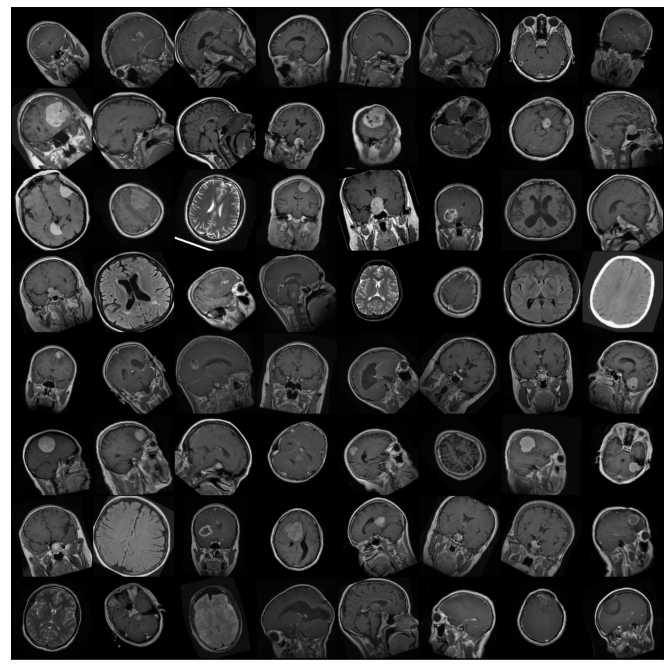

In [14]:
show_batch(train_dl)

GPU utilities

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
device = get_default_device()
device

device(type='cuda')

In [17]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

Defining accuracy and training architecture

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

Model creation

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.input_norm = nn.BatchNorm2d(3, affine=False)
        self.conv1 =  conv_block(in_channels, 8, pool=True) # 16 x 32 x 32
        self.conv2 =  conv_block(8, 16, pool=True)
        self.conv3 = conv_block(16, 32, pool=True) # 32 x 16 x 16

        self.conv4 = conv_block(32, 64, pool=True) # 64 x 8 x 8
        self.conv5 = conv_block(64, 128, pool=True) # 128 x 4x 4
        self.conv6 =  conv_block(128, 256) # 256 x 2 x 2
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2),
                                        nn.Flatten(),   #256
                                        nn.Dropout(0.2),
                                        nn.Linear(256, 128),
                                        nn.BatchNorm1d(128),
                                        nn.Linear(128,64),nn.BatchNorm1d(64),
                                        nn.Linear(64,num_classes)) # 10 
        
    def forward(self, xb):
        xb  = self.input_norm(xb)
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        #print(out.shape)
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, 4), device)
model

ResNet9(
  (input_norm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=F

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.2706185579299927, 'val_loss': 1.386660099029541}]

In [ ]:
epochs = 100
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00042, train_loss: 0.8949, val_loss: 1.5532, val_acc: 0.1878
Epoch [1], last_lr: 0.00050, train_loss: 0.7732, val_loss: 1.8727, val_acc: 0.2411
Epoch [2], last_lr: 0.00062, train_loss: 0.6887, val_loss: 1.6401, val_acc: 0.3909
Epoch [3], last_lr: 0.00080, train_loss: 0.6481, val_loss: 2.0738, val_acc: 0.4873
Epoch [4], last_lr: 0.00102, train_loss: 0.5745, val_loss: 2.7730, val_acc: 0.4112
Epoch [5], last_lr: 0.00129, train_loss: 0.5218, val_loss: 3.0882, val_acc: 0.3731
Epoch [6], last_lr: 0.00161, train_loss: 0.4858, val_loss: 6.5379, val_acc: 0.2716
Epoch [7], last_lr: 0.00196, train_loss: 0.4453, val_loss: 4.6820, val_acc: 0.3401
Epoch [8], last_lr: 0.00235, train_loss: 0.4249, val_loss: 6.8539, val_acc: 0.2716
Epoch [9], last_lr: 0.00277, train_loss: 0.3880, val_loss: 3.8318, val_acc: 0.4569
Epoch [10], last_lr: 0.00322, train_loss: 0.3584, val_loss: 5.2818, val_acc: 0.3325
Epoch [11], last_lr: 0.00369, train_loss: 0.3541, val_loss: 2.4624, val_acc: 0.5254
Ep

Therefore, a maximum accuracy of 76% was obtained on the test data set.

In [50]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

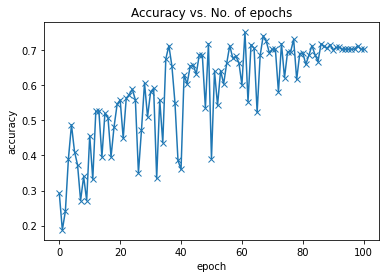

In [ ]:
plot_accuracies(history)

In [51]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

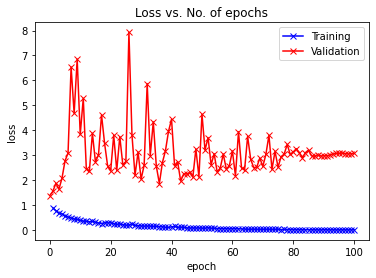

In [ ]:
plot_losses(history)

In [52]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

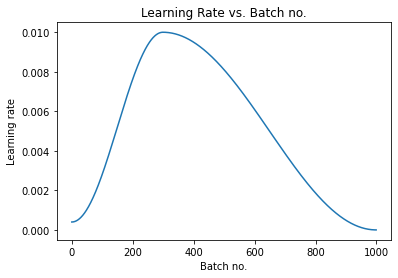

In [ ]:
plot_lrs(history)

In [53]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: glioma_tumor , Predicted: no_tumor


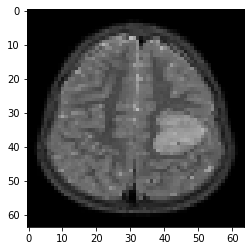

In [ ]:
img, label = valid_ds[36]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: glioma_tumor , Predicted: no_tumor


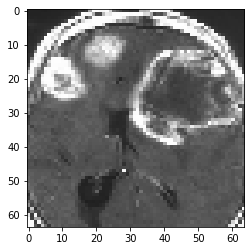

In [ ]:
img, label = valid_ds[45]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: glioma_tumor , Predicted: no_tumor


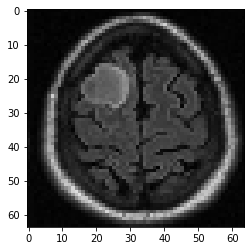

In [ ]:
img, label = valid_ds[2]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Therefore its observed that glioma_tumor is mistaken for 80% of the cases which is giving major error

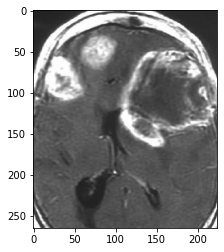

In [ ]:
img, label = valid_ds[222]
plt.imshow(img.permute(1, 2, 0))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(valid_ds, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.703045666217804, 'val_loss': 3.076019525527954}

Therefore, We achieved an Accuracy of 70.4%.

Lets now import a pretrained model trained on the ImageNet dataset having 1000 classes and see if it improves our accuracy

In [18]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))


## Modifying a Pretrained Model (ResNet34)

Transfer learning ([source](https://mc.ai/transfer-learning-with-deep-learning-machine-learning-techniques/)):
![transfer-learning](https://miro.medium.com/max/1000/1*LUFUl_8fqS97nUzpcFjgWw.png)


In [43]:
from torchvision import models

class BrainTumour(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained) #pretrained inherits the weights when it was trained
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [20]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [21]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
device = get_default_device()
device

device(type='cuda')

In [44]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [46]:
model = BrainTumour(4)
to_device(model, device);

In [47]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.27157360315322876, 'val_loss': 1.4928728342056274}]

In [48]:
epochs = 50
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [49]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0],last_lr: 0.00049, train_loss: 0.5352, val_loss: 3.6223, val_acc: 0.5609



Epoch [1],last_lr: 0.00079, train_loss: 0.2084, val_loss: 6.7681, val_acc: 0.4848



Epoch [2],last_lr: 0.00128, train_loss: 0.1575, val_loss: 2.9881, val_acc: 0.5635


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f02c26a7ef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f02c26a7ef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho


Epoch [3],last_lr: 0.00194, train_loss: 0.1553, val_loss: 3.8799, val_acc: 0.4112


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f02c26a7ef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f02c26a7ef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho


Epoch [4],last_lr: 0.00275, train_loss: 0.2012, val_loss: 16.8416, val_acc: 0.3096


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f02c26a7ef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f02c26a7ef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho


Epoch [5],last_lr: 0.00367, train_loss: 0.2187, val_loss: 3.9967, val_acc: 0.4670


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f02c26a7ef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f02c26a7ef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f02c26a7ef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch [6],last_lr: 0.00465, train_loss: 0.2071, val_loss: 4.4748, val_acc: 0.3782


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f02c26a7ef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f02c26a7ef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho


Epoch [7],last_lr: 0.00566, train_loss: 0.2668, val_loss: 5.9208, val_acc: 0.3325



Epoch [8],last_lr: 0.00665, train_loss: 0.2841, val_loss: 6.9939, val_acc: 0.2640



Epoch [9],last_lr: 0.00758, train_loss: 0.2985, val_loss: 2.7313, val_acc: 0.3528



Epoch [10],last_lr: 0.00840, train_loss: 0.2051, val_loss: 6.3732, val_acc: 0.2944



Epoch [11],last_lr: 0.00907, train_loss: 0.3054, val_loss: 12.7626, val_acc: 0.2665



Epoch [12],last_lr: 0.00958, train_loss: 0.2552, val_loss: 2.7747, val_acc: 0.5254



Epoch [13],last_lr: 0.00989, train_loss: 0.2048, val_loss: 6.2666, val_acc: 0.2665



Epoch [14],last_lr: 0.01000, train_loss: 0.1996, val_loss: 8.6573, val_acc: 0.3198



Epoch [15],last_lr: 0.00998, train_loss: 0.2563, val_loss: 6.3461, val_acc: 0.2817



Epoch [16],last_lr: 0.00992, train_loss: 0.2005, val_loss: 3.1211, val_acc: 0.4569



Epoch [17],last_lr: 0.00982, train_loss: 0.2136, val_loss: 2.1093, val_acc: 0.5508



Epoch [18],last_lr: 0.00968, train_loss: 0.1522, val_loss: 1.4238, val_acc: 0.7030



Epoch [19],last_lr: 0.00950, train_loss: 0.1318, val_loss: 2.9289, val_acc: 0.4898



Epoch [20],last_lr: 0.00929, train_loss: 0.1943, val_loss: 4.1309, val_acc: 0.4670



Epoch [21],last_lr: 0.00905, train_loss: 0.1628, val_loss: 3.2796, val_acc: 0.4898



Epoch [22],last_lr: 0.00877, train_loss: 0.1417, val_loss: 2.4461, val_acc: 0.5609



Epoch [23],last_lr: 0.00846, train_loss: 0.1238, val_loss: 3.7918, val_acc: 0.3756



Epoch [24],last_lr: 0.00812, train_loss: 0.1465, val_loss: 6.0098, val_acc: 0.2817



Epoch [25],last_lr: 0.00775, train_loss: 0.1709, val_loss: 1.0957, val_acc: 0.7183



Epoch [26],last_lr: 0.00737, train_loss: 0.1220, val_loss: 1.7533, val_acc: 0.7056



Epoch [27],last_lr: 0.00697, train_loss: 0.1042, val_loss: 1.5832, val_acc: 0.7005



Epoch [28],last_lr: 0.00655, train_loss: 0.0920, val_loss: 1.8655, val_acc: 0.5609



Epoch [29],last_lr: 0.00611, train_loss: 0.1362, val_loss: 2.6315, val_acc: 0.6447



Epoch [30],last_lr: 0.00567, train_loss: 0.1038, val_loss: 2.0826, val_acc: 0.6421



Epoch [31],last_lr: 0.00522, train_loss: 0.0794, val_loss: 1.3063, val_acc: 0.7411



Epoch [32],last_lr: 0.00478, train_loss: 0.0636, val_loss: 1.5471, val_acc: 0.7107



Epoch [33],last_lr: 0.00433, train_loss: 0.0699, val_loss: 2.0510, val_acc: 0.6878



Epoch [34],last_lr: 0.00389, train_loss: 0.0602, val_loss: 2.1623, val_acc: 0.7056



Epoch [35],last_lr: 0.00345, train_loss: 0.0565, val_loss: 1.7312, val_acc: 0.6675



Epoch [36],last_lr: 0.00303, train_loss: 0.0514, val_loss: 1.9272, val_acc: 0.7310



Epoch [37],last_lr: 0.00263, train_loss: 0.0404, val_loss: 1.8730, val_acc: 0.7360



Epoch [38],last_lr: 0.00225, train_loss: 0.0397, val_loss: 1.5812, val_acc: 0.7589



Epoch [39],last_lr: 0.00188, train_loss: 0.0415, val_loss: 1.5717, val_acc: 0.7741



Epoch [40],last_lr: 0.00154, train_loss: 0.0276, val_loss: 1.5242, val_acc: 0.7868



Epoch [41],last_lr: 0.00123, train_loss: 0.0249, val_loss: 1.5128, val_acc: 0.7487



Epoch [42],last_lr: 0.00095, train_loss: 0.0204, val_loss: 1.8064, val_acc: 0.7411



Epoch [43],last_lr: 0.00071, train_loss: 0.0162, val_loss: 1.6675, val_acc: 0.7690



Epoch [44],last_lr: 0.00050, train_loss: 0.0163, val_loss: 1.6541, val_acc: 0.7817



Epoch [45],last_lr: 0.00032, train_loss: 0.0099, val_loss: 1.7201, val_acc: 0.7741



Epoch [46],last_lr: 0.00018, train_loss: 0.0123, val_loss: 1.7504, val_acc: 0.7741



Epoch [47],last_lr: 0.00008, train_loss: 0.0169, val_loss: 1.7427, val_acc: 0.7817



Epoch [48],last_lr: 0.00002, train_loss: 0.0066, val_loss: 1.7201, val_acc: 0.7817



Epoch [49],last_lr: 0.00000, train_loss: 0.0106, val_loss: 1.7335, val_acc: 0.7741
CPU times: user 4min 15s, sys: 4min 6s, total: 8min 21s
Wall time: 25min 50s


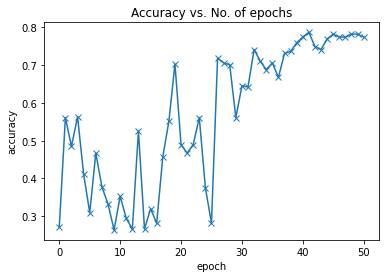

In [54]:
plot_accuracies(history)

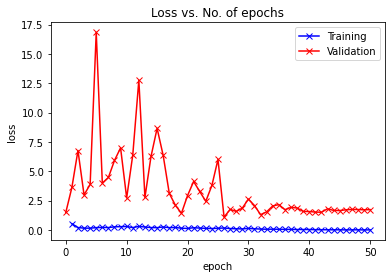

In [55]:
plot_losses(history)

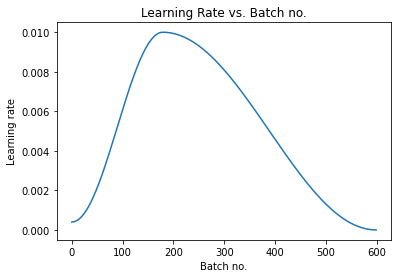

In [56]:
plot_lrs(history)

In [57]:
test_loader = DeviceDataLoader(DataLoader(valid_ds, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.7741116881370544, 'val_loss': 1.7334626913070679}

Therefore using ResNet Model we were able to achieve a greater accuracy of 77.4% and the accuracy obtained using our model was close to 70.4%.
This can be explained because of pretrained weights of ResNet model and also because of less availability of training data

Label: meningioma_tumor , Predicted: meningioma_tumor


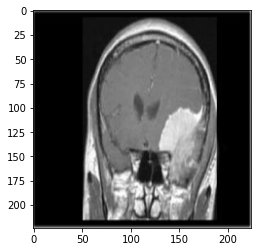

In [61]:
img, label = valid_ds[100]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: no_tumor , Predicted: no_tumor


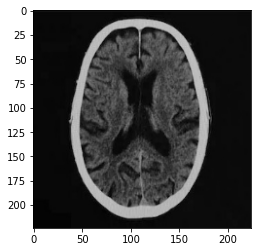

In [62]:
img, label = valid_ds[220]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: no_tumor , Predicted: no_tumor


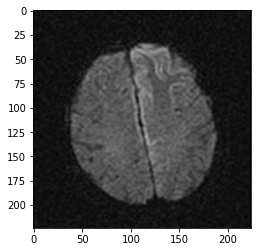

In [64]:
img, label = valid_ds[312]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

In [67]:
!pip install jovian --upgrade -q
import jovian
jovian.submit(assignment="zerotogans-project")


     |████████████████████████████████| 68 kB 3.9 MB/s 
[jovian] Detected Colab notebook...


[jovian] Error: jovian.commit doesn't work on Colab unless the notebook was created and executed from Jovian.
Make sure to run the first code cell at the top after executing from Jovian.
Alternatively, you can download this notebook and upload it manually to Jovian.
Learn more: https://jovian.ai/docs/user-guide/run.html#run-on-colab
